<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 41

# Student 1: Nikhil Patni

# Student 2: Silvia Sultana

# Student 3: Aishvarya Viswanathan

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

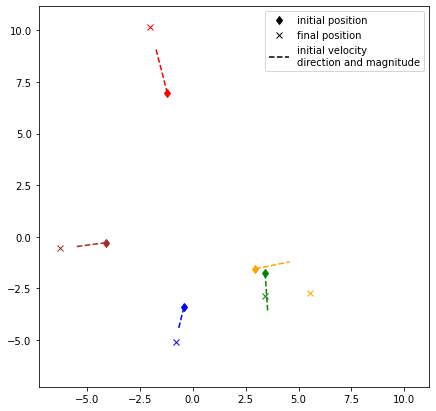

In [7]:
random_idx = np.random.randint(0, 100)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [9]:
print(len(positions_train))

10000


In [11]:
positions_train.shape

(10000, 4, 2, 5)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np

class MyDataset(Dataset):
    def __init__(self, initial_pos, final_pos, initial_v, charges):
        self.initial_pos = torch.FloatTensor(initial_pos)
        self.final_pos = torch.FloatTensor(final_pos)
        self.initial_v = torch.FloatTensor(initial_v)
        self.charges = torch.FloatTensor(charges)
        
    def __getitem__(self, index):
        position = self.initial_pos[index]
        final = self.final_pos[index]
        velocity = self.initial_v[index]
        charge = self.charges[index]

        return position, final, velocity, charge
   
    def __len__(self):
        return len(self.initial_pos)

In [13]:
# Dataset Formation and DataLoader
initial_pos = positions_train[:,0,:,:]
final_pos_1 = positions_train[:,1,:,:] #prediction for first time step
final_pos_2 = positions_train[:,2,:,:] #prediction for second time step
final_pos_3 = positions_train[:,3,:,:] #prediction for third time step
initial_v = velocities_train[:,0,:,:]
charges = charges_train[:,:,0]

val_initial_pos = positions_valid[:,0,:,:]
val_final_pos_1 = positions_valid[:,1,:,:]
val_final_pos_2 = positions_valid[:,2,:,:]
val_final_pos_3 = positions_valid[:,3,:,:]
val_initial_v = velocities_valid[:,0,:,:]
val_charges = charges_valid[:,:,0]

#create training data for t=0.5
train_data_1 = MyDataset(initial_pos, final_pos_1, initial_v, charges)
val_data_1= MyDataset(val_initial_pos, val_final_pos_1, val_initial_v, val_charges)

#create training data for t=1.0
train_data_2= MyDataset(initial_pos, final_pos_2, initial_v, charges)
val_data_2 = MyDataset(val_initial_pos, val_final_pos_2, val_initial_v, val_charges)

#create training data for t=1.5
train_data_3 = MyDataset(initial_pos, final_pos_3, initial_v, charges)
val_data_3= MyDataset(val_initial_pos, val_final_pos_3, val_initial_v, val_charges)

#train and valid loader for t=0.5
train_loader_1 = torch.utils.data.DataLoader(train_data_1, batch_size=8)
val_loader_1 = torch.utils.data.DataLoader(val_data_1, batch_size=8)

#train and valid loader for t=1.0
train_loader_2 = torch.utils.data.DataLoader(train_data_2, batch_size=8)
val_loader_2 = torch.utils.data.DataLoader(val_data_2, batch_size=8)

#train and valid loader for t=1.5
train_loader_3 = torch.utils.data.DataLoader(train_data_3, batch_size=8)
val_loader_3 = torch.utils.data.DataLoader(val_data_3, batch_size=8)

In [14]:
next(iter(train_loader_1))

[tensor([[[-1.9361,  3.6532, -4.5496, -3.0958,  0.1073],
          [-0.2276, -2.7631,  8.2998, -3.0921, -2.8976]],
 
         [[-0.1263,  0.2471,  2.7077, -5.7338,  1.5066],
          [ 2.7799,  2.3619,  3.6385, -1.2817, -3.4543]],
 
         [[ 3.3470, -1.1958,  0.8698,  2.9774, -1.0611],
          [-3.4571,  0.4730,  2.3725, -2.5351,  0.1758]],
 
         [[-3.2892,  1.2890,  3.2644, -3.1801, -2.0062],
          [-0.4152, -2.6863,  1.7522, -0.9213,  0.4708]],
 
         [[ 0.9667, -0.4748,  1.6789, -1.3763,  1.0445],
          [-0.7228, -1.7157,  0.2298,  3.6835,  0.0638]],
 
         [[ 2.6428,  3.8593,  2.5115, -1.4686,  1.3598],
          [ 0.9855,  0.8726, -1.3138,  1.2768, -1.6419]],
 
         [[ 0.1484,  0.5587,  3.4641, -1.0538, -0.3224],
          [ 2.0086, -1.1389,  4.9956, -3.0921,  2.9877]],
 
         [[ 0.3704,  1.4087,  0.9847, -5.1987,  3.0423],
          [ 1.3492,  3.6293, -5.3249, -0.7860, -1.6906]]]),
 tensor([[[-2.3387e+00,  4.4387e+00, -5.1946e+00, -4.0422e+00,  

In [15]:
#test final position for t=0.5
test_initial_pos = positions_test[:,0,:,:]
test_final_pos_1= positions_test[:,1,:,:]
test_final_pos_2= positions_test[:,2,:,:]
test_final_pos_3= positions_test[:,3,:,:]
test_initial_v = velocities_test[:,0,:,:]
test_charges = charges_test[:,:,0]


test_data_1 = MyDataset(test_initial_pos, test_final_pos_1, test_initial_v, test_charges)
test_loader_1 = torch.utils.data.DataLoader(test_data_1, batch_size=5)


test_data_2 = MyDataset(test_initial_pos, test_final_pos_2, test_initial_v, test_charges)
test_loader_2 = torch.utils.data.DataLoader(test_data_2, batch_size=5)

test_data_3 = MyDataset(test_initial_pos, test_final_pos_3, test_initial_v, test_charges)
test_loader_3 = torch.utils.data.DataLoader(test_data_3, batch_size=5)

In [16]:
test_initial_pos

array([[[ 0.859266  ,  0.12506237, -0.04622387,  2.15083051,
         -2.911576  ],
        [ 0.63971399, -1.39133946, -1.71711858,  2.69405784,
          0.53112595]],

       [[ 1.0603079 , -0.46967702,  1.30928829, -2.29615764,
          1.35007167],
        [ 3.64720779, -0.06737261,  1.06247355,  1.49755506,
         -3.43051632]],

       [[-0.34228439,  1.05395224,  1.25831868, -0.19372056,
         -0.67168656],
        [ 0.21973615, -1.1958711 , -1.16004567, -1.12452183,
          0.13743422]],

       ...,

       [[ 2.68226549,  2.46473778,  2.7410639 , -6.94159582,
         -5.40179594],
        [ 0.35901131,  2.88713473,  3.12434091,  3.30314618,
         -8.37808934]],

       [[-2.06017773,  2.91513419,  1.22734167,  3.16599914,
         -0.62989315],
        [-5.60472299,  4.43555985,  0.8736154 , -0.71369079,
          2.61763016]],

       [[ 1.91205721, -0.88604453, -4.65577582, -1.70139281,
          1.1810602 ],
        [ 1.63717614, -0.52761471, -0.74429396, -0.06

In [17]:
def input_target(position, final, velocity, charge):
    initial_x = position[0][0][:]
    initial_y = position[0][1][:]
    final_x = final[0][0][:]
    final_y = final[0][1][:]
    v_x = velocity[0][0][:]
    v_y = velocity[0][1][:]
    ch = charge[0][:]

    input = torch.cat((initial_x, initial_y, v_x, v_y, ch))
    target = torch.cat((final_x, final_y))

    return input, target

# Model Implementation

In [18]:
import torch.nn as nn
from torch import optim
import torch
import torch.nn.functional as F

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(25, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 10)
    )

  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [19]:
# Initialize the MLP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP()
model = model.to(device)

# Define the loss function and optimizer

In [20]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'MLP-checkpoint_1.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [21]:
print(len(train_loader_1))

1250


# Model Training

In [22]:
import tqdm, time

# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    best_val_acc = 0.0
    epoch_best = 0
    epoch_val_best = 0
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        tr_acc = []
        model.train()
        print("Starting epoch " + str(epoch+1))
        # ============ Training ============ #
        for position, final, velocity, charge in train_loader:
            #plot_case(99,train_data,labels)
            initial_pos, target_pos = input_target(position, final, velocity, charge)
            initial_pos = initial_pos.to(device)
            target_pos = target_pos.to(device)
            #case_loss = 0.0
            #print(initial_pos)
            optimizer.zero_grad()
            outputs = model(initial_pos)
            loss = torch.sqrt(criterion(outputs, target_pos))

            #case_loss += loss.item()
            # Backward and optimize
            loss.backward()
            optimizer.step()

            #print(outputs, target_pos)
            running_loss += loss.item()
            #print(running_loss)
            #breakpoint()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # ============ Validation ============ #
        val_running_loss = 0.0
        va_acc = []
        with torch.no_grad():
            model.eval()
            for position, final, velocity, charge in val_loader:
                #case_loss = 0.0
                initial_pos, target_pos = input_target(position, final, velocity, charge)
                initial_pos = initial_pos.to(device)
                target_pos = target_pos.to(device)
                outputs = model(initial_pos)
                loss = torch.sqrt(criterion(outputs, target_pos))

                #case_loss += loss.item()

                val_running_loss += loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, elapsed_time: {:.4f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss, time.time()-start_time))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epoch_val_best = epoch+1
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses, best_val_loss, epoch_val_best

In [23]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 9.6 MB/s 


# Evaluation



In [24]:
def test_input_target(position, final, velocity, charge, time):
    initial_x = position[0][0][:]
    initial_y = position[0][1][:]
    final_x = final[0][0][:]
    final_y = final[0][1][:]
    v_x = velocity[0][0][:]
    v_y = velocity[0][1][:]
    ch = charge[0][:]
    baseline_x = initial_x + v_x*time
    baseline_y = initial_y + v_y*time

    input = torch.cat((initial_x, initial_y, v_x, v_y, ch))
    target = torch.cat((final_x, final_y))
    baseline = torch.cat((baseline_x, baseline_y))

    return input, target, baseline

In [25]:
from torchmetrics import R2Score
r2score = R2Score().to(device)

# ============ Testing ============ #
def eval(model, test_loader, criterion, time):
    with torch.no_grad():
        correct = 0
        count = 0
        test_loss = 0.0
        r2_score = 0.0
        test_loss_baseline = 0.0
        r2_score_baseline = 0.0
        for position, final, velocity, charge in test_loader:
            initial_pos, target_pos, baseline_pos = test_input_target(position, final, velocity, charge, time)
            initial_pos = initial_pos.to(device)
            target_pos = target_pos.to(device)
            baseline_pos = baseline_pos.to(device)

            outputs = model(initial_pos)
            rmse_loss = torch.sqrt(criterion(outputs, target_pos))
            score = r2score(outputs, target_pos)
            rmse_loss_baseline = torch.sqrt(criterion(outputs, baseline_pos))
            score_baseline = r2score(outputs, baseline_pos)

            #case_loss += loss.item()

            test_loss += rmse_loss.item()
            r2_score += score
            test_loss_baseline += rmse_loss_baseline.item()
            r2_score_baseline += score_baseline
            count+=1
            if count % 200 == 0:
                print("Output pos: ", outputs)
                print("Actual pos: ", target_pos)
                print("Baseline pos: ", baseline_pos)
                print(f"RMSE Loss after {count} simulations:", test_loss/count)
                print("\n")

    avg_test_loss = test_loss / len(test_loader)
    avg_r2_score = r2_score / len(test_loader)
    avg_test_loss_baseline = test_loss_baseline / len(test_loader)
    avg_r2_score_baseline = r2_score_baseline / len(test_loader)
    return avg_test_loss, avg_r2_score, avg_test_loss_baseline, avg_r2_score_baseline

t=0 -> t=0.5

In [26]:
# actual training for different batch sizes 
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = nn.MSELoss()

save_path = 'MLP-checkpoint_1.pt'
train_losses_1, val_losses_1, best_val_loss_1, epoch_loss_1 = train(model, train_loader_1, val_loader_1, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/100], train_loss: 2.0652, val_loss: 1.1642, elapsed_time: 4.0114
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 2
Epoch [2/100], train_loss: 0.8281, val_loss: 0.6529, elapsed_time: 5.0374
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 3
Epoch [3/100], train_loss: 0.5706, val_loss: 0.5160, elapsed_time: 4.1260
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 4
Epoch [4/100], train_loss: 0.4807, val_loss: 0.4574, elapsed_time: 3.6563
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 5
Epoch [5/100], train_loss: 0.4300, val_loss: 0.4194, elapsed_time: 3.6208
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 6
Epoch [6/100], train_loss: 0.3948, val_loss: 0.3935, elapsed_time: 3.6230
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 7
Epoch [7/100], train_loss: 0.3691, val_loss: 0.3749, elapsed_time: 3.6350
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 8
Epoch [8/100], train_loss: 0.3492, val_loss: 0.3617, elapsed_time: 3.6722

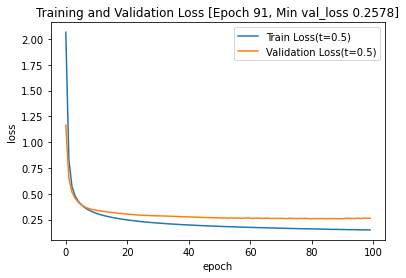

In [27]:
# plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses_1, label='Train Loss(t=0.5)')
plt.plot(val_losses_1, label="Validation Loss(t=0.5)")
plt.title("Training and Validation Loss [Epoch {}, Min val_loss {:.4f}]".format(epoch_loss_1, best_val_loss_1))
plt.legend(loc='upper right')
plt.show()

In [28]:
# Testing on previously trained model
import torch.optim as optim
load_model = MLP().to(device)
load_optimizer = optim.Adam(model.parameters(),lr=1e-4)

best_val_loss = load_checkpoint(load_model, load_optimizer)

print('Best val_loss: {:.8f}'.format(best_val_loss))

test_loss, r2_score, test_loss_baseline, r2_score_baseline = eval(load_model, test_loader_1, criterion, 0.5)
print('RMSE Loss on test data: {:.4f}, RMSE loss compared with baseline: {:.4f}'.format(test_loss, test_loss_baseline))
print('R2_score: {:.4f}, R2_score compared with baseline: {:.4f}'.format(r2_score, r2_score_baseline))

Model loaded from <== MLP-checkpoint_1.pt
Best val_loss: 0.25780349
Output pos:  tensor([ 0.0168,  0.5074,  2.7617,  1.5701, -4.9942,  0.9387,  1.1818,  2.1095,
        -1.6903,  3.9510], device='cuda:0')
Actual pos:  tensor([-0.1832,  0.5443,  2.7473,  1.3889, -5.0052,  1.2809,  1.0530,  2.1327,
        -1.5505,  3.6140], device='cuda:0')
Baseline pos:  tensor([-0.3589,  0.7272,  2.7361,  1.3901, -5.0023,  1.3473,  0.9892,  2.1130,
        -1.5322,  3.6129], device='cuda:0')
RMSE Loss after 200 simulations: 0.27221459928900005


Output pos:  tensor([-2.1268,  3.7209, -0.4928, -1.0912,  1.8467, -1.5773, -2.9427,  2.0966,
         2.3009, -2.1118], device='cuda:0')
Actual pos:  tensor([-2.1900,  3.6610, -0.6610, -0.6277,  1.9556, -1.0905, -2.9526,  2.0430,
         2.0230, -2.2324], device='cuda:0')
Baseline pos:  tensor([-2.1965,  3.6863, -0.1967, -1.0901,  1.9350, -1.0902, -2.9674,  1.6473,
         2.4179, -2.2169], device='cuda:0')
RMSE Loss after 400 simulations: 0.2739377911575139

t=0 -> t=1

In [29]:
# actual training
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

save_path = 'MLP-checkpoint_1.pt'
train_losses_1, val_losses_1, best_val_loss_1, epoch_loss_1 = train(model, train_loader_2, val_loader_2, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/100], train_loss: 0.3196, val_loss: 0.4183, elapsed_time: 3.8114
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 2
Epoch [2/100], train_loss: 0.3036, val_loss: 0.4194, elapsed_time: 4.5919
Starting epoch 3
Epoch [3/100], train_loss: 0.2982, val_loss: 0.4214, elapsed_time: 4.7670
Starting epoch 4
Epoch [4/100], train_loss: 0.2944, val_loss: 0.4216, elapsed_time: 3.6669
Starting epoch 5
Epoch [5/100], train_loss: 0.2912, val_loss: 0.4230, elapsed_time: 3.7173
Starting epoch 6
Epoch [6/100], train_loss: 0.2887, val_loss: 0.4227, elapsed_time: 3.6831
Starting epoch 7
Epoch [7/100], train_loss: 0.2866, val_loss: 0.4245, elapsed_time: 3.6879
Starting epoch 8
Epoch [8/100], train_loss: 0.2842, val_loss: 0.4283, elapsed_time: 3.7264
Starting epoch 9
Epoch [9/100], train_loss: 0.2827, val_loss: 0.4213, elapsed_time: 3.6781
Starting epoch 10
Epoch [10/100], train_loss: 0.2811, val_loss: 0.4345, elapsed_time: 3.6854
Starting epoch 11
Epoch [11/100], train_loss: 0.2

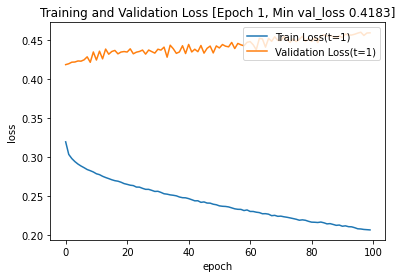

In [30]:
# plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses_1, label='Train Loss(t=1)')
plt.plot(val_losses_1, label="Validation Loss(t=1)")
plt.title("Training and Validation Loss [Epoch {}, Min val_loss {:.4f}]".format(epoch_loss_1, best_val_loss_1))
plt.legend(loc='upper right')
plt.show()

In [31]:
# Testing on previously trained model
import torch.optim as optim
load_model = MLP().to(device)
load_optimizer = optim.Adam(model.parameters(),lr=1e-4)

best_val_loss = load_checkpoint(load_model, load_optimizer)

print('Best val_loss: {:.8f}'.format(best_val_loss))

test_loss, r2_score, test_loss_baseline, r2_score_baseline = eval(load_model, test_loader_2, criterion, 1)
print('RMSE Loss on test data: {:.4f}, RMSE loss compared with baseline: {:.4f}'.format(test_loss, test_loss_baseline))
print('R2_score: {:.4f}, R2_score compared with baseline: {:.4f}'.format(r2_score, r2_score_baseline))

Model loaded from <== MLP-checkpoint_1.pt
Best val_loss: 0.41830563
Output pos:  tensor([-0.0359,  0.4712,  2.9832,  1.8261, -5.4901,  1.1578,  1.2313,  2.1766,
        -1.9904,  4.4691], device='cuda:0')
Actual pos:  tensor([ 0.3558, -0.2007,  3.4183,  1.4193, -5.5438,  1.5030,  1.2700,  2.2479,
        -1.6340,  3.8536], device='cuda:0')
Baseline pos:  tensor([-0.6233,  0.8033,  3.3763,  1.4254, -5.5328,  1.5768,  1.2014,  2.1829,
        -1.5697,  3.8491], device='cuda:0')
RMSE Loss after 200 simulations: 0.4346496071666479


Output pos:  tensor([-2.3804,  4.2887, -0.6864, -1.2712,  2.1387, -1.4990, -3.3588,  2.2076,
         2.7036, -2.3168], device='cuda:0')
Actual pos:  tensor([-2.4174,  3.9788, -0.7478, -0.7317,  2.4002, -0.8706, -3.1489,  2.1728,
         2.4587, -2.7947], device='cuda:0')
Baseline pos:  tensor([-2.4378,  4.0912, -0.0060, -1.4693,  2.3040, -0.8683, -3.2049,  1.6674,
         2.9617, -2.7387], device='cuda:0')
RMSE Loss after 400 simulations: 0.43335452511906625

t=0 -> t=1.5

In [32]:
#training model for predicting position at t=0.5
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

save_path = 'MLP-checkpoint_1.pt'
train_losses_1, val_losses_1, best_val_loss_1, epoch_loss_1 = train(model, train_loader_3, val_loader_3, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/100], train_loss: 0.7329, val_loss: 0.8646, elapsed_time: 3.7211
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 2
Epoch [2/100], train_loss: 0.7013, val_loss: 0.8218, elapsed_time: 3.6528
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 3
Epoch [3/100], train_loss: 0.6753, val_loss: 0.8087, elapsed_time: 3.7006
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 4
Epoch [4/100], train_loss: 0.6628, val_loss: 0.8030, elapsed_time: 3.6589
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 5
Epoch [5/100], train_loss: 0.6502, val_loss: 0.8191, elapsed_time: 3.7026
Starting epoch 6
Epoch [6/100], train_loss: 0.6412, val_loss: 0.8498, elapsed_time: 3.6993
Starting epoch 7
Epoch [7/100], train_loss: 0.6289, val_loss: 0.7818, elapsed_time: 3.7151
Model saved to ==> MLP-checkpoint_1.pt
Starting epoch 8
Epoch [8/100], train_loss: 0.6206, val_loss: 0.8371, elapsed_time: 3.6869
Starting epoch 9
Epoch [9/100], train_loss: 0.6172, val_loss: 0.8452, elapsed

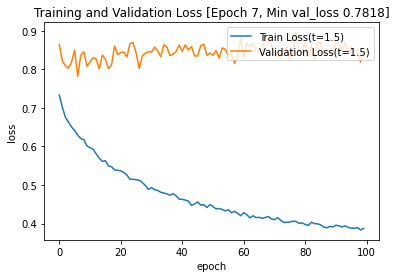

In [33]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses_1, label='Train Loss(t=1.5)')
plt.plot(val_losses_1, label="Validation Loss(t=1.5)")
plt.title("Training and Validation Loss [Epoch {}, Min val_loss {:.4f}]".format(epoch_loss_1, best_val_loss_1))
plt.legend( loc='upper right')
plt.show()

In [34]:
# Testing on previously trained model
import torch.optim as optim
load_model = MLP().to(device)
load_optimizer = optim.Adam(model.parameters(),lr=1e-4)

best_val_loss = load_checkpoint(load_model, load_optimizer)

print('Best val_loss: {:.8f}'.format(best_val_loss))

test_loss, r2_score, test_loss_baseline, r2_score_baseline = eval(load_model, test_loader_3, criterion, 1.5)
print('RMSE Loss on test data: {:.4f}, RMSE loss compared with baseline: {:.4f}'.format(test_loss, test_loss_baseline))
print('R2_score: {:.4f}, R2_score compared with baseline: {:.4f}'.format(r2_score, r2_score_baseline))

Model loaded from <== MLP-checkpoint_1.pt
Best val_loss: 0.78179713
Output pos:  tensor([-0.2293,  1.0885,  2.8630,  2.3574, -5.8970,  1.2922,  0.4080,  3.1776,
        -1.9576,  4.3588], device='cuda:0')
Actual pos:  tensor([ 0.7452, -0.7940,  4.0934,  1.4494, -6.0883,  1.9828,  1.2282,  2.3744,
        -1.7309,  4.0963], device='cuda:0')
Baseline pos:  tensor([-0.8877,  0.8794,  4.0165,  1.4607, -6.0632,  1.8063,  1.4136,  2.2528,
        -1.6071,  4.0853], device='cuda:0')
RMSE Loss after 200 simulations: 0.8125611709058285


Output pos:  tensor([-3.0175,  4.1656, -0.4199, -1.5989,  2.7717, -1.5077, -4.4956,  3.8893,
         3.5552, -3.2522], device='cuda:0')
Actual pos:  tensor([-2.6417,  4.2059, -0.6923, -0.9775,  2.9318, -0.6528, -3.3275,  2.7840,
         2.4131, -3.3730], device='cuda:0')
Baseline pos:  tensor([-2.6790,  4.4960,  0.1848, -1.8486,  2.6730, -0.6465, -3.4424,  1.6875,
         3.5055, -3.2604], device='cuda:0')
RMSE Loss after 400 simulations: 0.8109790281206369
